# Neural Network Model

In [1]:
# Construct neural network model structure

def intitializeAgent():
    
    model = Sequential() 
    
    model.add(Dense(256,activation='relu',input_shape=(INPUT_SIZE,)))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(OUTPUT_SIZE,activation='linear'))
    
    model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    
    return model

In [2]:
# Update network weights

def updateTargetNetwork():
    target.set_weights(agent.get_weights())

In [3]:
# Predict based on the returned envrionment using the neural network
# Return output as a part of the training labels

def getPrediction(env,agent):
    env = env.reshape(INPUT_SIZE,1).reshape(1,-1)
    return agent.predict(env)[0]

## Exponential Epsilon Decay
Exponentially decaying epsilon: $\varepsilon = \varepsilon _{min}^{i/iterations}$, where $i$ is in range (0, iterations).

In [4]:
# Return the action using exponential epsilon decay for training

def getAction(output,invalidActions):
    rand = np.random.rand()
    output[invalidActions] = np.min(output) - 0.1  # Make sure invalid actions will not be chosen based on greedy strategy
    
    if rand < EPSILON_RATE ** iteration:  # Randomly choose actions and avoid invalid actions
        action = np.random.randint(OUTPUT_SIZE)
        while action in invalidActions:
            action = np.random.randint(OUTPUT_SIZE)
        return action
    else:  # Greedy stategy
        return np.argmax(output)

In [5]:
# Get action based on greedy strategy for comparison

def getGreedyAction(output,invalidActions):
    output[invalidActions] = np.min(output) - 0.1  # Make sure invalid actions will not be chosen
    return np.argmax(output)

In [6]:
# Train the neural network

def train(initialStateMemory,actionMemory,rewardMemory,finalStateMemory,evalnet,targetnet,epochs):
    
    if memCount < MAX_MEM_SIZE:
        s = np.random.choice(memCount, SAMPLE_SIZE)
    else:
        s = np.random.choice(MAX_MEM_SIZE, SAMPLE_SIZE)
    batchSize = s.shape[0] // BATCH_SIZE
    
    if batchSize == 0:
        batchSize = 1
                
    targetQs = getTargetQs(initialStateMemory[s], actionMemory[s], rewardMemory[s], finalStateMemory[s], evalnet, targetnet)
        
    print("Training Model...")
    evalnet.fit(initialStateMemory[s],targetQs,batch_size = batchSize, epochs = epochs, verbose = 0)

# Replay Memory

In [7]:
def addMemory(initialState, action, reward, finalState, memCount, MAX_MEM_SIZE):
    if memCount < MAX_MEM_SIZE:
        initialStateMemory[memCount] = initialState.reshape(INPUT_SIZE)
        actionMemory[memCount] = action
        rewardMemory[memCount] = reward
        finalStateMemory[memCount] = finalState.reshape(INPUT_SIZE)
    else:
        rand = np.random.randint(MAX_MEM_SIZE)
        initialStateMemory[rand] = initialState.reshape(INPUT_SIZE)
        actionMemory[rand] = action
        rewardMemory[rand] = reward
        finalStateMemory[rand] = finalState.reshape(INPUT_SIZE)

    memCount += 1
        
    return initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount

In [8]:
# Create Q-Table and update

def getTargetQs(states0, actions, rewards, states1, evalnet, targetnet):
    DISCOUNT = 0.99
    sample_size = len(states0)
    
    evalnetQs = np.zeros((sample_size, OUTPUT_SIZE))
    targetnetQs = np.zeros((sample_size, OUTPUT_SIZE))
    currentStateQs = np.zeros((sample_size, OUTPUT_SIZE))
    
    evalnetQs = np.array([getPrediction(states1[i], evalnet) for i in range(sample_size)])
    targetnetQs = np.array([getPrediction(states1[i], targetnet) for i in range(sample_size)])
    currentStateQs = np.array([getPrediction(states0[i], evalnet) for i in range(sample_size)])
    targetQs = currentStateQs
    
    argmaxActions = np.argmax(evalnetQs, axis = 1)
    indices = np.arange(len(states0))
    
    targetQs[indices, actions] = rewards + DISCOUNT * targetnetQs[indices,argmaxActions]
    
    return targetQs

# Game

Initialize an environment as an array, each value correspond to the number shown in the game as a 4*4 table.

In [62]:
def initializeEnv():
    env = np.zeros((BOARD_LENGTH,BOARD_LENGTH))

    for i in range(2):
        addValue(env)
            
    return env

Randomly choose an empty place to fill in a value 2, representing the newly-grenerated block.

In [63]:
def addValue(env):

    value = 2
        
    coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
    coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
        
    if env[coordinate1,coordinate2] != 0:
        getNewCoordinate(env,value)
    else:
        env[coordinate1,coordinate2] = value
        
    return env

In [64]:
def getNewCoordinate(env,value):
    
    coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
    coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
    
    while env[coordinate1,coordinate2] != 0:
        coordinate1 = random.sample(range(0,BOARD_LENGTH),1)
        coordinate2 = random.sample(range(0,BOARD_LENGTH),1)
    
    env[coordinate1,coordinate2] = value

Define the actions and consequences that the agent take.

In [65]:
def step(env,action,score):
    
    if action == 0:
        env, score, validAction, maxscore = actionUp(env,score)
    if action == 1:
        env, score, validAction, maxscore = actionDown(env,score)
    if action == 2:
        env, score, validAction, maxscore = actionLeft(env,score)
    if action == 3:
        env, score, validAction, maxscore = actionRight(env,score)
    
    return env, score, validAction, maxscore

In [66]:
def actionUp(env,score):
    validAction = False
    maxscore = 0
    
    for i in range(BOARD_LENGTH):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 0:
                if env[row - 1][j] != 0:
                    if env[row - 1][j] == env[row][j]:
                        env[row - 1][j] *= 2
                        env[row][j] = 0
                        score += env[row - 1][j]
                        maxscore = env.max()
                        validAction = True
                    break
                temp = env[row][j]
                env[row-1][j] = temp
                env[row][j] = 0
                row -= 1
                validAction = True
    return env, score, validAction, maxscore

In [67]:
def actionDown(env,score):
    validAction = False
    maxscore = 0
    
    for i in range(3,-1,-1):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 3:
                if env[row + 1][j] != 0:
                    if env[row + 1][j] == env[row][j]:
                        env[row + 1][j] *= 2
                        env[row][j] = 0
                        score += env[row + 1][j]
                        maxscore = env.max()
                        validAction = True
                    break
                temp = env[row][j]
                env[row + 1][j] = temp
                env[row][j] = 0
                row += 1
                validAction = True
    return env, score, validAction,maxscore

In [68]:
def actionLeft(env,score):
    validAction = False
    env = env.T
    maxscore = 0
    
    for i in range(BOARD_LENGTH):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 0:
                if env[row - 1][j] != 0:
                    if env[row - 1][j] == env[row][j]:
                        env[row - 1][j] *= 2
                        env[row][j] = 0
                        score += env[row - 1][j]
                        maxscore = env.max()
                        validAction = True
                    break
                temp = env[row][j]
                env[row-1][j] = temp
                env[row][j] = 0
                row -= 1
                validAction = True
    env = env.T
    return env, score, validAction, maxscore

In [69]:
def actionRight(env,score):
    validAction = False
    env = env.T
    maxscore = 0
    
    for i in range(3,-1,-1):
        for j in range(BOARD_LENGTH):
            row = i
            while env[row][j] != 0 and row != 3:
                if env[row + 1][j] != 0:
                    if env[row + 1][j] == env[row][j]:
                        env[row + 1][j] *= 2
                        env[row][j] = 0
                        score += env[row + 1][j]
                        maxscore = env.max()
                        validAction = True
                    break
                temp = env[row][j]
                env[row + 1][j] = temp
                env[row][j] = 0
                row += 1
                validAction = True
    env = env.T
    return env, score, validAction, maxscore

Check if there are blocks with the same value next to each other to tell whether there is availability for next move.

In [70]:
def getAvailableAction(env):
    tempEnv = np.copy(env)
    available = False
    
    for i in range(tempEnv.shape[0]):
        for j in range(tempEnv.shape[0] - 1):
            if tempEnv[i][j] == tempEnv[i][j+1]:
                available = True
                
                
    tempEnv = tempEnv.T
    for i in range(tempEnv.shape[0]):
        for j in range(tempEnv.shape[0] - 1):
            if tempEnv[i][j] == tempEnv[i][j+1]:
                available = True
                break
    
    return available

In [71]:
def run(env,agent,memCount,testFlag,score = 0):
    
    gameOver = False
    while gameOver == False:
        invalidActions = []
        validAction = False
        while validAction == False:
            
            '''
            Use of testFlag: 
            True: comparison mode, using greedy strategy
            False: train mode, using exponential epsilon decay strategy
            '''
            
            if not testFlag:
                previousEnv = np.copy(env)
                previousScore = np.copy(score)
            
            output = getPrediction(env,agent)  # Intermediate labels
            if testFlag: 
                action = getGreedyAction(output,invalidActions) 
            else: 
                action = getAction(output,invalidActions)
            invalidActions.append(action)
            env, score, validAction, maxscore = step(env, action, score)
        
        if not testFlag:
            initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount = addMemory(previousEnv, action, score - previousScore, env, memCount, MAX_MEM_SIZE)

        env = addValue(env)  # Generate random blocks
        
        if np.sum(env == 0) == 0:  # Check if there is available action when all blocks are filled
            gameOver = not getAvailableAction(env)
    
    if not testFlag:
        return score,initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount
    else: 
        return score, maxscore

# Training and Testing

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import time
import sys

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout

In [23]:
BOARD_LENGTH = 4
INPUT_SIZE = 16
OUTPUT_SIZE = BOARD_LENGTH 

memCount = 0
MAX_MEM_SIZE = 100_000
SAMPLE_SIZE = MAX_MEM_SIZE // 200
BATCH_SIZE = SAMPLE_SIZE // 100
initialStateMemory = np.zeros((MAX_MEM_SIZE,INPUT_SIZE))
actionMemory = np.zeros(MAX_MEM_SIZE, dtype = np.int)
rewardMemory = np.zeros(MAX_MEM_SIZE)
finalStateMemory = np.zeros((MAX_MEM_SIZE,INPUT_SIZE))


gameScoreLog = []
greedyScoreLog = []
agent = intitializeAgent()
target = intitializeAgent()
updateTargetNetwork()

/var/folders/w5/21854l7s6fgbzlwq2vpx6ts80000gn/T/ipykernel_16156/504751816.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actionMemory = np.zeros(MAX_MEM_SIZE, dtype = np.int)


In [26]:
ITERATIONS = 1000
EPISODES = 100
TESTS = EPISODES // 5
EPOCHS = 4
ITER_PER_UPDATE = 25
MIN_EPSILON = 0.05
EPSILON_RATE = MIN_EPSILON ** (1./ITERATIONS)

## Train the agent

In [19]:
def printIter():
    print("\n === === === Iteration",iteration,"of",ITERATIONS,'=== === ===\n')

In [20]:
def printStats(timeLog,iteration,ITERATIONS,memCount,scoreLog,greedyScoreLog,EPISODES,TESTS):
    print("\nEstimated time remaining: ", format(np.mean(timeLog) * (ITERATIONS - iteration) / 60,'.2f')," Minutes\n")
    print("Memories Elapsed: ",memCount)
    print("Current Epsilon: ",format(EPSILON_RATE ** iteration,'.4f'))
    print("Ave Game Score for Epoch: ", format(np.mean(scoreLog[len(scoreLog) - EPISODES : len(scoreLog)-1]) ,'.2f'))
    print("Ave Greedy Score for Epoch: ", format(np.mean(greedyScoreLog[len(greedyScoreLog) - TESTS : len(greedyScoreLog)-1]) ,'.2f'))

In [21]:
def printTrainInfo():
    print("Maximum memory size:",MAX_MEM_SIZE)
    print("Sample size for training:",SAMPLE_SIZE)
    print("Batch size from sample:",BATCH_SIZE)
    print("Epslon Rate:",format(EPSILON_RATE,'.4f'))

In [27]:
startTime = time.time()
timeLog = []

printTrainInfo()

for iteration in range(ITERATIONS): # For each iteration, run 25 episodes and 5 tests
    printIter()
    iterationStart = time.time()
    
    for i in range(EPISODES):
        score,initialStateMemory,actionMemory,rewardMemory,finalStateMemory,memCount = run(initializeEnv(),agent,memCount,False)
        gameScoreLog.append(score)
    
    for i in range(TESTS):
        score = run(initializeEnv(),agent,memCount,True)
        greedyScoreLog.append(score)
        
    train(initialStateMemory,actionMemory,rewardMemory,finalStateMemory,agent,target,EPOCHS)
    timeLog.append(time.time() - iterationStart)
    
    if iteration % ITER_PER_UPDATE == 0:  # Update Q-Table
        updateTargetNetwork()
    
    if EPISODES != 25:
        startTime = time.time()
        timeLog = []
        greedyScoreLog = []
        gameScoreLog = []
    
    printStats(timeLog,iteration,ITERATIONS,memCount,gameScoreLog,greedyScoreLog,EPISODES,TESTS)
    
    EPISODES = 25
    TESTS = EPISODES // 5

Maximum memory size: 100000
Sample size for training: 500
Batch size from sample: 5
Epslon Rate: 0.9970

 === === === Iteration 0 of 1000 === === ===

Training Model...

Estimated time remaining:  nan  Minutes

Memories Elapsed:  69519
Current Epsilon:  1.0000
Ave Game Score for Epoch:  nan
Ave Greedy Score for Epoch:  nan

 === === === Iteration 1 of 1000 === === ===

Training Model...

Estimated time remaining:  1653.44  Minutes

Memories Elapsed:  73263
Current Epsilon:  0.9970
Ave Game Score for Epoch:  1397.00
Ave Greedy Score for Epoch:  1225.00

 === === === Iteration 2 of 1000 === === ===

Training Model...

Estimated time remaining:  1597.50  Minutes

Memories Elapsed:  76821
Current Epsilon:  0.9940
Ave Game Score for Epoch:  1287.50
Ave Greedy Score for Epoch:  1701.00

 === === === Iteration 3 of 1000 === === ===

Training Model...

Estimated time remaining:  1618.94  Minutes

Memories Elapsed:  80576
Current Epsilon:  0.9911
Ave Game Score for Epoch:  1438.17
Ave Greedy Sc

Training Model...

Estimated time remaining:  1351.48  Minutes

Memories Elapsed:  192419
Current Epsilon:  0.9005
Ave Game Score for Epoch:  1150.50
Ave Greedy Score for Epoch:  2115.00

 === === === Iteration 36 of 1000 === === ===

Training Model...

Estimated time remaining:  1345.30  Minutes

Memories Elapsed:  195718
Current Epsilon:  0.8978
Ave Game Score for Epoch:  1137.83
Ave Greedy Score for Epoch:  965.00

 === === === Iteration 37 of 1000 === === ===

Training Model...

Estimated time remaining:  1340.29  Minutes

Memories Elapsed:  199004
Current Epsilon:  0.8951
Ave Game Score for Epoch:  1172.67
Ave Greedy Score for Epoch:  1260.00

 === === === Iteration 38 of 1000 === === ===

Training Model...

Estimated time remaining:  1339.13  Minutes

Memories Elapsed:  202737
Current Epsilon:  0.8924
Ave Game Score for Epoch:  1398.00
Ave Greedy Score for Epoch:  1824.00

 === === === Iteration 39 of 1000 === === ===

Training Model...

Estimated time remaining:  1336.41  Minute

Training Model...

Estimated time remaining:  1302.78  Minutes

Memories Elapsed:  317344
Current Epsilon:  0.8108
Ave Game Score for Epoch:  1235.83
Ave Greedy Score for Epoch:  3369.00

 === === === Iteration 71 of 1000 === === ===

Training Model...

Estimated time remaining:  1303.13  Minutes

Memories Elapsed:  320960
Current Epsilon:  0.8084
Ave Game Score for Epoch:  1325.00
Ave Greedy Score for Epoch:  2485.00

 === === === Iteration 72 of 1000 === === ===

Training Model...

Estimated time remaining:  1302.06  Minutes

Memories Elapsed:  324545
Current Epsilon:  0.8060
Ave Game Score for Epoch:  1320.67
Ave Greedy Score for Epoch:  2167.00

 === === === Iteration 73 of 1000 === === ===

Training Model...

Estimated time remaining:  1300.65  Minutes

Memories Elapsed:  328221
Current Epsilon:  0.8036
Ave Game Score for Epoch:  1342.33
Ave Greedy Score for Epoch:  1310.00

 === === === Iteration 74 of 1000 === === ===

Training Model...

Estimated time remaining:  1296.67  Minut

Training Model...

Estimated time remaining:  1259.01  Minutes

Memories Elapsed:  440898
Current Epsilon:  0.7301
Ave Game Score for Epoch:  1289.17
Ave Greedy Score for Epoch:  2921.00

 === === === Iteration 106 of 1000 === === ===

Training Model...

Estimated time remaining:  1257.39  Minutes

Memories Elapsed:  444059
Current Epsilon:  0.7279
Ave Game Score for Epoch:  1104.83
Ave Greedy Score for Epoch:  2224.00

 === === === Iteration 107 of 1000 === === ===

Training Model...

Estimated time remaining:  1257.02  Minutes

Memories Elapsed:  447571
Current Epsilon:  0.7258
Ave Game Score for Epoch:  1301.50
Ave Greedy Score for Epoch:  2721.00

 === === === Iteration 108 of 1000 === === ===

Training Model...

Estimated time remaining:  1254.78  Minutes

Memories Elapsed:  450954
Current Epsilon:  0.7236
Ave Game Score for Epoch:  1168.83
Ave Greedy Score for Epoch:  1151.00

 === === === Iteration 109 of 1000 === === ===

Training Model...

Estimated time remaining:  1253.26  M

Training Model...

Estimated time remaining:  1228.85  Minutes

Memories Elapsed:  561668
Current Epsilon:  0.6574
Ave Game Score for Epoch:  1200.50
Ave Greedy Score for Epoch:  616.00

 === === === Iteration 141 of 1000 === === ===

Training Model...

Estimated time remaining:  1226.49  Minutes

Memories Elapsed:  565080
Current Epsilon:  0.6555
Ave Game Score for Epoch:  1234.17
Ave Greedy Score for Epoch:  1286.00

 === === === Iteration 142 of 1000 === === ===

Training Model...

Estimated time remaining:  1225.41  Minutes

Memories Elapsed:  568763
Current Epsilon:  0.6535
Ave Game Score for Epoch:  1363.83
Ave Greedy Score for Epoch:  2584.00

 === === === Iteration 143 of 1000 === === ===

Training Model...

Estimated time remaining:  1224.37  Minutes

Memories Elapsed:  572491
Current Epsilon:  0.6516
Ave Game Score for Epoch:  1390.00
Ave Greedy Score for Epoch:  2926.00

 === === === Iteration 144 of 1000 === === ===

Training Model...

Estimated time remaining:  1222.13  Mi

Training Model...

Estimated time remaining:  1172.92  Minutes

Memories Elapsed:  683771
Current Epsilon:  0.5920
Ave Game Score for Epoch:  1239.83
Ave Greedy Score for Epoch:  3311.00

 === === === Iteration 176 of 1000 === === ===

Training Model...

Estimated time remaining:  1171.66  Minutes

Memories Elapsed:  687433
Current Epsilon:  0.5902
Ave Game Score for Epoch:  1356.00
Ave Greedy Score for Epoch:  2018.00

 === === === Iteration 177 of 1000 === === ===

Training Model...

Estimated time remaining:  1170.27  Minutes

Memories Elapsed:  690997
Current Epsilon:  0.5885
Ave Game Score for Epoch:  1275.67
Ave Greedy Score for Epoch:  2207.00

 === === === Iteration 178 of 1000 === === ===

Training Model...

Estimated time remaining:  1168.40  Minutes

Memories Elapsed:  694545
Current Epsilon:  0.5867
Ave Game Score for Epoch:  1353.83
Ave Greedy Score for Epoch:  1353.00

 === === === Iteration 179 of 1000 === === ===

Training Model...

Estimated time remaining:  1165.82  M

Training Model...

Estimated time remaining:  1116.75  Minutes

Memories Elapsed:  804348
Current Epsilon:  0.5331
Ave Game Score for Epoch:  1330.17
Ave Greedy Score for Epoch:  2393.00

 === === === Iteration 211 of 1000 === === ===

Training Model...

Estimated time remaining:  1115.56  Minutes

Memories Elapsed:  808041
Current Epsilon:  0.5315
Ave Game Score for Epoch:  1368.33
Ave Greedy Score for Epoch:  2594.00

 === === === Iteration 212 of 1000 === === ===

Training Model...

Estimated time remaining:  1114.10  Minutes

Memories Elapsed:  811446
Current Epsilon:  0.5299
Ave Game Score for Epoch:  1177.17
Ave Greedy Score for Epoch:  2312.00

 === === === Iteration 213 of 1000 === === ===

Training Model...

Estimated time remaining:  1112.52  Minutes

Memories Elapsed:  814706
Current Epsilon:  0.5283
Ave Game Score for Epoch:  1144.50
Ave Greedy Score for Epoch:  2689.00

 === === === Iteration 214 of 1000 === === ===

Training Model...

Estimated time remaining:  1111.33  M

Training Model...

Estimated time remaining:  1070.54  Minutes

Memories Elapsed:  927421
Current Epsilon:  0.4800
Ave Game Score for Epoch:  1083.17
Ave Greedy Score for Epoch:  1206.00

 === === === Iteration 246 of 1000 === === ===

Training Model...

Estimated time remaining:  1069.45  Minutes

Memories Elapsed:  931063
Current Epsilon:  0.4786
Ave Game Score for Epoch:  1271.00
Ave Greedy Score for Epoch:  2345.00

 === === === Iteration 247 of 1000 === === ===

Training Model...

Estimated time remaining:  1068.39  Minutes

Memories Elapsed:  934839
Current Epsilon:  0.4771
Ave Game Score for Epoch:  1402.17
Ave Greedy Score for Epoch:  2044.00

 === === === Iteration 248 of 1000 === === ===

Training Model...

Estimated time remaining:  1066.73  Minutes

Memories Elapsed:  937905
Current Epsilon:  0.4757
Ave Game Score for Epoch:  1005.83
Ave Greedy Score for Epoch:  2673.00

 === === === Iteration 249 of 1000 === === ===

Training Model...

Estimated time remaining:  1065.34  M

Training Model...

Estimated time remaining:  1023.36  Minutes

Memories Elapsed:  1050538
Current Epsilon:  0.4322
Ave Game Score for Epoch:  1187.67
Ave Greedy Score for Epoch:  1522.00

 === === === Iteration 281 of 1000 === === ===

Training Model...

Estimated time remaining:  1021.65  Minutes

Memories Elapsed:  1054040
Current Epsilon:  0.4309
Ave Game Score for Epoch:  1283.00
Ave Greedy Score for Epoch:  998.00

 === === === Iteration 282 of 1000 === === ===

Training Model...

Estimated time remaining:  1020.74  Minutes

Memories Elapsed:  1057816
Current Epsilon:  0.4296
Ave Game Score for Epoch:  1410.67
Ave Greedy Score for Epoch:  3308.00

 === === === Iteration 283 of 1000 === === ===

Training Model...

Estimated time remaining:  1019.09  Minutes

Memories Elapsed:  1060793
Current Epsilon:  0.4284
Ave Game Score for Epoch:  972.33
Ave Greedy Score for Epoch:  2508.00

 === === === Iteration 284 of 1000 === === ===

Training Model...

Estimated time remaining:  1017.86 

Training Model...

Estimated time remaining:  974.57  Minutes

Memories Elapsed:  1170856
Current Epsilon:  0.3892
Ave Game Score for Epoch:  1184.33
Ave Greedy Score for Epoch:  1376.00

 === === === Iteration 316 of 1000 === === ===

Training Model...

Estimated time remaining:  973.45  Minutes

Memories Elapsed:  1174591
Current Epsilon:  0.3880
Ave Game Score for Epoch:  1332.50
Ave Greedy Score for Epoch:  3075.00

 === === === Iteration 317 of 1000 === === ===

Training Model...

Estimated time remaining:  972.39  Minutes

Memories Elapsed:  1178167
Current Epsilon:  0.3869
Ave Game Score for Epoch:  1271.67
Ave Greedy Score for Epoch:  3917.00

 === === === Iteration 318 of 1000 === === ===

Training Model...

Estimated time remaining:  970.98  Minutes

Memories Elapsed:  1181783
Current Epsilon:  0.3857
Ave Game Score for Epoch:  1295.00
Ave Greedy Score for Epoch:  1268.00

 === === === Iteration 319 of 1000 === === ===

Training Model...

Estimated time remaining:  969.59  Mi

Training Model...

Estimated time remaining:  926.56  Minutes

Memories Elapsed:  1294726
Current Epsilon:  0.3505
Ave Game Score for Epoch:  1106.17
Ave Greedy Score for Epoch:  916.00

 === === === Iteration 351 of 1000 === === ===

Training Model...

Estimated time remaining:  925.32  Minutes

Memories Elapsed:  1298799
Current Epsilon:  0.3494
Ave Game Score for Epoch:  1589.67
Ave Greedy Score for Epoch:  1611.00

 === === === Iteration 352 of 1000 === === ===

Training Model...

Estimated time remaining:  923.37  Minutes

Memories Elapsed:  1301685
Current Epsilon:  0.3484
Ave Game Score for Epoch:  950.83
Ave Greedy Score for Epoch:  836.00

 === === === Iteration 353 of 1000 === === ===

Training Model...

Estimated time remaining:  921.87  Minutes

Memories Elapsed:  1305111
Current Epsilon:  0.3473
Ave Game Score for Epoch:  1217.50
Ave Greedy Score for Epoch:  1934.00

 === === === Iteration 354 of 1000 === === ===

Training Model...

Estimated time remaining:  920.18  Minut

Training Model...

Estimated time remaining:  1033.40  Minutes

Memories Elapsed:  1419155
Current Epsilon:  0.3156
Ave Game Score for Epoch:  1175.17
Ave Greedy Score for Epoch:  866.00

 === === === Iteration 386 of 1000 === === ===

Training Model...

Estimated time remaining:  1031.47  Minutes

Memories Elapsed:  1422850
Current Epsilon:  0.3146
Ave Game Score for Epoch:  1404.50
Ave Greedy Score for Epoch:  2187.00

 === === === Iteration 387 of 1000 === === ===

Training Model...

Estimated time remaining:  1029.74  Minutes

Memories Elapsed:  1426461
Current Epsilon:  0.3137
Ave Game Score for Epoch:  1311.67
Ave Greedy Score for Epoch:  3324.00

 === === === Iteration 388 of 1000 === === ===

Training Model...

Estimated time remaining:  1027.92  Minutes

Memories Elapsed:  1430207
Current Epsilon:  0.3128
Ave Game Score for Epoch:  1369.17
Ave Greedy Score for Epoch:  2460.00

 === === === Iteration 389 of 1000 === === ===

Training Model...

Estimated time remaining:  1025.87

Training Model...

Estimated time remaining:  968.18  Minutes

Memories Elapsed:  1546576
Current Epsilon:  0.2842
Ave Game Score for Epoch:  1105.33
Ave Greedy Score for Epoch:  1118.00

 === === === Iteration 421 of 1000 === === ===

Training Model...

Estimated time remaining:  966.15  Minutes

Memories Elapsed:  1549885
Current Epsilon:  0.2833
Ave Game Score for Epoch:  1108.33
Ave Greedy Score for Epoch:  1587.00

 === === === Iteration 422 of 1000 === === ===

Training Model...

Estimated time remaining:  964.05  Minutes

Memories Elapsed:  1553136
Current Epsilon:  0.2825
Ave Game Score for Epoch:  1127.83
Ave Greedy Score for Epoch:  1421.00

 === === === Iteration 423 of 1000 === === ===

Training Model...

Estimated time remaining:  962.39  Minutes

Memories Elapsed:  1556994
Current Epsilon:  0.2816
Ave Game Score for Epoch:  1386.67
Ave Greedy Score for Epoch:  3134.00

 === === === Iteration 424 of 1000 === === ===

Training Model...

Estimated time remaining:  960.22  Mi

Training Model...

Estimated time remaining:  920.94  Minutes

Memories Elapsed:  1673208
Current Epsilon:  0.2559
Ave Game Score for Epoch:  1557.50
Ave Greedy Score for Epoch:  1786.00

 === === === Iteration 456 of 1000 === === ===

Training Model...

Estimated time remaining:  919.43  Minutes

Memories Elapsed:  1677122
Current Epsilon:  0.2551
Ave Game Score for Epoch:  1476.50
Ave Greedy Score for Epoch:  2511.00

 === === === Iteration 457 of 1000 === === ===

Training Model...

Estimated time remaining:  917.76  Minutes

Memories Elapsed:  1680688
Current Epsilon:  0.2543
Ave Game Score for Epoch:  1276.33
Ave Greedy Score for Epoch:  2387.00

 === === === Iteration 458 of 1000 === === ===

Training Model...

Estimated time remaining:  916.25  Minutes

Memories Elapsed:  1684763
Current Epsilon:  0.2536
Ave Game Score for Epoch:  1502.17
Ave Greedy Score for Epoch:  1821.00

 === === === Iteration 459 of 1000 === === ===

Training Model...

Estimated time remaining:  914.62  Mi

Training Model...

Estimated time remaining:  866.05  Minutes

Memories Elapsed:  1805709
Current Epsilon:  0.2304
Ave Game Score for Epoch:  1554.67
Ave Greedy Score for Epoch:  2733.00

 === === === Iteration 491 of 1000 === === ===

Training Model...

Estimated time remaining:  864.06  Minutes

Memories Elapsed:  1808599
Current Epsilon:  0.2297
Ave Game Score for Epoch:  962.33
Ave Greedy Score for Epoch:  1006.00

 === === === Iteration 492 of 1000 === === ===

Training Model...

Estimated time remaining:  862.05  Minutes

Memories Elapsed:  1811430
Current Epsilon:  0.2290
Ave Game Score for Epoch:  949.67
Ave Greedy Score for Epoch:  1362.00

 === === === Iteration 493 of 1000 === === ===

Training Model...

Estimated time remaining:  860.58  Minutes

Memories Elapsed:  1815318
Current Epsilon:  0.2283
Ave Game Score for Epoch:  1474.33
Ave Greedy Score for Epoch:  2919.00

 === === === Iteration 494 of 1000 === === ===

Training Model...

Estimated time remaining:  858.55  Minu

Training Model...

Estimated time remaining:  809.03  Minutes

Memories Elapsed:  1933599
Current Epsilon:  0.2075
Ave Game Score for Epoch:  1104.17
Ave Greedy Score for Epoch:  1342.00

 === === === Iteration 526 of 1000 === === ===

Training Model...

Estimated time remaining:  807.04  Minutes

Memories Elapsed:  1936301
Current Epsilon:  0.2069
Ave Game Score for Epoch:  839.33
Ave Greedy Score for Epoch:  1392.00

 === === === Iteration 527 of 1000 === === ===

Training Model...

Estimated time remaining:  805.58  Minutes

Memories Elapsed:  1940580
Current Epsilon:  0.2062
Ave Game Score for Epoch:  1675.00
Ave Greedy Score for Epoch:  1942.00

 === === === Iteration 528 of 1000 === === ===

Training Model...

Estimated time remaining:  804.19  Minutes

Memories Elapsed:  1945046
Current Epsilon:  0.2056
Ave Game Score for Epoch:  1827.83
Ave Greedy Score for Epoch:  2703.00

 === === === Iteration 529 of 1000 === === ===

Training Model...

Estimated time remaining:  802.62  Min

Training Model...

Estimated time remaining:  753.69  Minutes

Memories Elapsed:  2070342
Current Epsilon:  0.1868
Ave Game Score for Epoch:  1570.17
Ave Greedy Score for Epoch:  1457.00

 === === === Iteration 561 of 1000 === === ===

Training Model...

Estimated time remaining:  752.30  Minutes

Memories Elapsed:  2074982
Current Epsilon:  0.1863
Ave Game Score for Epoch:  1774.17
Ave Greedy Score for Epoch:  2530.00

 === === === Iteration 562 of 1000 === === ===

Training Model...

Estimated time remaining:  750.73  Minutes

Memories Elapsed:  2079176
Current Epsilon:  0.1857
Ave Game Score for Epoch:  1658.50
Ave Greedy Score for Epoch:  2195.00

 === === === Iteration 563 of 1000 === === ===

Training Model...

Estimated time remaining:  748.81  Minutes

Memories Elapsed:  2082297
Current Epsilon:  0.1851
Ave Game Score for Epoch:  1070.00
Ave Greedy Score for Epoch:  886.00

 === === === Iteration 564 of 1000 === === ===

Training Model...

Estimated time remaining:  747.25  Min

Training Model...

Estimated time remaining:  698.33  Minutes

Memories Elapsed:  2210247
Current Epsilon:  0.1682
Ave Game Score for Epoch:  1830.17
Ave Greedy Score for Epoch:  2309.00

 === === === Iteration 596 of 1000 === === ===

Training Model...

Estimated time remaining:  696.83  Minutes

Memories Elapsed:  2214721
Current Epsilon:  0.1677
Ave Game Score for Epoch:  1789.17
Ave Greedy Score for Epoch:  2408.00

 === === === Iteration 597 of 1000 === === ===

Training Model...

Estimated time remaining:  695.26  Minutes

Memories Elapsed:  2218400
Current Epsilon:  0.1672
Ave Game Score for Epoch:  1337.17
Ave Greedy Score for Epoch:  3846.00

 === === === Iteration 598 of 1000 === === ===

Training Model...

Estimated time remaining:  693.29  Minutes

Memories Elapsed:  2221135
Current Epsilon:  0.1667
Ave Game Score for Epoch:  829.83
Ave Greedy Score for Epoch:  1154.00

 === === === Iteration 599 of 1000 === === ===

Training Model...

Estimated time remaining:  691.82  Min

Training Model...

Estimated time remaining:  641.90  Minutes

Memories Elapsed:  2350564
Current Epsilon:  0.1515
Ave Game Score for Epoch:  1719.83
Ave Greedy Score for Epoch:  2508.00

 === === === Iteration 631 of 1000 === === ===

Training Model...

Estimated time remaining:  640.39  Minutes

Memories Elapsed:  2355245
Current Epsilon:  0.1510
Ave Game Score for Epoch:  1927.50
Ave Greedy Score for Epoch:  2252.00

 === === === Iteration 632 of 1000 === === ===

Training Model...

Estimated time remaining:  638.81  Minutes

Memories Elapsed:  2359330
Current Epsilon:  0.1506
Ave Game Score for Epoch:  1503.67
Ave Greedy Score for Epoch:  3160.00

 === === === Iteration 633 of 1000 === === ===

Training Model...

Estimated time remaining:  637.26  Minutes

Memories Elapsed:  2363628
Current Epsilon:  0.1501
Ave Game Score for Epoch:  1734.17
Ave Greedy Score for Epoch:  2689.00

 === === === Iteration 634 of 1000 === === ===

Training Model...

Estimated time remaining:  635.68  Mi

Training Model...

Estimated time remaining:  582.98  Minutes

Memories Elapsed:  2485101
Current Epsilon:  0.1364
Ave Game Score for Epoch:  1299.33
Ave Greedy Score for Epoch:  3087.00

 === === === Iteration 666 of 1000 === === ===

Training Model...

Estimated time remaining:  581.39  Minutes

Memories Elapsed:  2489256
Current Epsilon:  0.1360
Ave Game Score for Epoch:  1583.50
Ave Greedy Score for Epoch:  2622.00

 === === === Iteration 667 of 1000 === === ===

Training Model...

Estimated time remaining:  579.87  Minutes

Memories Elapsed:  2493947
Current Epsilon:  0.1356
Ave Game Score for Epoch:  1856.67
Ave Greedy Score for Epoch:  2025.00

 === === === Iteration 668 of 1000 === === ===

Training Model...

Estimated time remaining:  578.26  Minutes

Memories Elapsed:  2497898
Current Epsilon:  0.1352
Ave Game Score for Epoch:  1458.33
Ave Greedy Score for Epoch:  3406.00

 === === === Iteration 669 of 1000 === === ===

Training Model...

Estimated time remaining:  576.81  Mi

Training Model...

Estimated time remaining:  526.09  Minutes

Memories Elapsed:  2631880
Current Epsilon:  0.1228
Ave Game Score for Epoch:  910.50
Ave Greedy Score for Epoch:  1410.00

 === === === Iteration 701 of 1000 === === ===

Training Model...

Estimated time remaining:  524.47  Minutes

Memories Elapsed:  2635959
Current Epsilon:  0.1225
Ave Game Score for Epoch:  1445.17
Ave Greedy Score for Epoch:  3412.00

 === === === Iteration 702 of 1000 === === ===

Training Model...

Estimated time remaining:  522.78  Minutes

Memories Elapsed:  2640138
Current Epsilon:  0.1221
Ave Game Score for Epoch:  1582.17
Ave Greedy Score for Epoch:  1405.00

 === === === Iteration 703 of 1000 === === ===

Training Model...

Estimated time remaining:  521.11  Minutes

Memories Elapsed:  2644163
Current Epsilon:  0.1217
Ave Game Score for Epoch:  1445.83
Ave Greedy Score for Epoch:  2155.00

 === === === Iteration 704 of 1000 === === ===

Training Model...

Estimated time remaining:  519.63  Min

Training Model...

Estimated time remaining:  467.89  Minutes

Memories Elapsed:  2781124
Current Epsilon:  0.1106
Ave Game Score for Epoch:  1538.17
Ave Greedy Score for Epoch:  3228.00

 === === === Iteration 736 of 1000 === === ===

Training Model...

Estimated time remaining:  466.13  Minutes

Memories Elapsed:  2785205
Current Epsilon:  0.1103
Ave Game Score for Epoch:  1553.83
Ave Greedy Score for Epoch:  2664.00

 === === === Iteration 737 of 1000 === === ===

Training Model...

Estimated time remaining:  464.40  Minutes

Memories Elapsed:  2789551
Current Epsilon:  0.1099
Ave Game Score for Epoch:  1560.83
Ave Greedy Score for Epoch:  3336.00

 === === === Iteration 738 of 1000 === === ===

Training Model...

Estimated time remaining:  462.71  Minutes

Memories Elapsed:  2794347
Current Epsilon:  0.1096
Ave Game Score for Epoch:  1813.33
Ave Greedy Score for Epoch:  2545.00

 === === === Iteration 739 of 1000 === === ===

Training Model...

Estimated time remaining:  460.97  Mi

Training Model...

Estimated time remaining:  407.54  Minutes

Memories Elapsed:  2941458
Current Epsilon:  0.0996
Ave Game Score for Epoch:  2410.33
Ave Greedy Score for Epoch:  2500.00

 === === === Iteration 771 of 1000 === === ===

Training Model...

Estimated time remaining:  405.82  Minutes

Memories Elapsed:  2945651
Current Epsilon:  0.0993
Ave Game Score for Epoch:  1594.17
Ave Greedy Score for Epoch:  2686.00

 === === === Iteration 772 of 1000 === === ===

Training Model...

Estimated time remaining:  404.13  Minutes

Memories Elapsed:  2950154
Current Epsilon:  0.0990
Ave Game Score for Epoch:  1790.83
Ave Greedy Score for Epoch:  3045.00

 === === === Iteration 773 of 1000 === === ===

Training Model...

Estimated time remaining:  402.38  Minutes

Memories Elapsed:  2954470
Current Epsilon:  0.0987
Ave Game Score for Epoch:  1650.17
Ave Greedy Score for Epoch:  3146.00

 === === === Iteration 774 of 1000 === === ===

Training Model...

Estimated time remaining:  400.69  Mi

Training Model...

Estimated time remaining:  347.41  Minutes

Memories Elapsed:  3103379
Current Epsilon:  0.0897
Ave Game Score for Epoch:  1877.17
Ave Greedy Score for Epoch:  3284.00

 === === === Iteration 806 of 1000 === === ===

Training Model...

Estimated time remaining:  345.65  Minutes

Memories Elapsed:  3107905
Current Epsilon:  0.0894
Ave Game Score for Epoch:  1782.00
Ave Greedy Score for Epoch:  2732.00

 === === === Iteration 807 of 1000 === === ===

Training Model...

Estimated time remaining:  343.94  Minutes

Memories Elapsed:  3112776
Current Epsilon:  0.0891
Ave Game Score for Epoch:  1949.00
Ave Greedy Score for Epoch:  2641.00

 === === === Iteration 808 of 1000 === === ===

Training Model...

Estimated time remaining:  342.16  Minutes

Memories Elapsed:  3117034
Current Epsilon:  0.0889
Ave Game Score for Epoch:  1643.50
Ave Greedy Score for Epoch:  2854.00

 === === === Iteration 809 of 1000 === === ===

Training Model...

Estimated time remaining:  340.40  Mi

Training Model...

Estimated time remaining:  285.87  Minutes

Memories Elapsed:  3265752
Current Epsilon:  0.0807
Ave Game Score for Epoch:  1797.67
Ave Greedy Score for Epoch:  2792.00

 === === === Iteration 841 of 1000 === === ===

Training Model...

Estimated time remaining:  284.09  Minutes

Memories Elapsed:  3270249
Current Epsilon:  0.0805
Ave Game Score for Epoch:  1787.33
Ave Greedy Score for Epoch:  1795.00

 === === === Iteration 842 of 1000 === === ===

Training Model...

Estimated time remaining:  282.33  Minutes

Memories Elapsed:  3275180
Current Epsilon:  0.0803
Ave Game Score for Epoch:  1918.67
Ave Greedy Score for Epoch:  2371.00

 === === === Iteration 843 of 1000 === === ===

Training Model...

Estimated time remaining:  280.59  Minutes

Memories Elapsed:  3280064
Current Epsilon:  0.0800
Ave Game Score for Epoch:  1943.83
Ave Greedy Score for Epoch:  2771.00

 === === === Iteration 844 of 1000 === === ===

Training Model...

Estimated time remaining:  278.81  Mi

Training Model...

Estimated time remaining:  224.02  Minutes

Memories Elapsed:  3430573
Current Epsilon:  0.0727
Ave Game Score for Epoch:  1681.33
Ave Greedy Score for Epoch:  3115.00

 === === === Iteration 876 of 1000 === === ===

Training Model...

Estimated time remaining:  222.25  Minutes

Memories Elapsed:  3435346
Current Epsilon:  0.0725
Ave Game Score for Epoch:  1930.50
Ave Greedy Score for Epoch:  2731.00

 === === === Iteration 877 of 1000 === === ===

Training Model...

Estimated time remaining:  220.51  Minutes

Memories Elapsed:  3440851
Current Epsilon:  0.0723
Ave Game Score for Epoch:  2232.33
Ave Greedy Score for Epoch:  3306.00

 === === === Iteration 878 of 1000 === === ===

Training Model...

Estimated time remaining:  218.74  Minutes

Memories Elapsed:  3445614
Current Epsilon:  0.0721
Ave Game Score for Epoch:  1792.33
Ave Greedy Score for Epoch:  2930.00

 === === === Iteration 879 of 1000 === === ===

Training Model...

Estimated time remaining:  216.95  Mi

Training Model...

Estimated time remaining:  161.80  Minutes

Memories Elapsed:  3600949
Current Epsilon:  0.0655
Ave Game Score for Epoch:  1702.17
Ave Greedy Score for Epoch:  3589.00

 === === === Iteration 911 of 1000 === === ===

Training Model...

Estimated time remaining:  160.02  Minutes

Memories Elapsed:  3605933
Current Epsilon:  0.0653
Ave Game Score for Epoch:  1971.00
Ave Greedy Score for Epoch:  3141.00

 === === === Iteration 912 of 1000 === === ===

Training Model...

Estimated time remaining:  158.23  Minutes

Memories Elapsed:  3610918
Current Epsilon:  0.0651
Ave Game Score for Epoch:  2039.17
Ave Greedy Score for Epoch:  1858.00

 === === === Iteration 913 of 1000 === === ===

Training Model...

Estimated time remaining:  156.43  Minutes

Memories Elapsed:  3615723
Current Epsilon:  0.0649
Ave Game Score for Epoch:  1933.83
Ave Greedy Score for Epoch:  2776.00

 === === === Iteration 914 of 1000 === === ===

Training Model...

Estimated time remaining:  154.65  Mi

Training Model...

Estimated time remaining:  99.10  Minutes

Memories Elapsed:  3774623
Current Epsilon:  0.0590
Ave Game Score for Epoch:  1785.17
Ave Greedy Score for Epoch:  3486.00

 === === === Iteration 946 of 1000 === === ===

Training Model...

Estimated time remaining:  97.31  Minutes

Memories Elapsed:  3779438
Current Epsilon:  0.0588
Ave Game Score for Epoch:  1878.17
Ave Greedy Score for Epoch:  2612.00

 === === === Iteration 947 of 1000 === === ===

Training Model...

Estimated time remaining:  95.52  Minutes

Memories Elapsed:  3784259
Current Epsilon:  0.0586
Ave Game Score for Epoch:  1901.33
Ave Greedy Score for Epoch:  2687.00

 === === === Iteration 948 of 1000 === === ===

Training Model...

Estimated time remaining:  93.73  Minutes

Memories Elapsed:  3789646
Current Epsilon:  0.0584
Ave Game Score for Epoch:  2319.67
Ave Greedy Score for Epoch:  2365.00

 === === === Iteration 949 of 1000 === === ===

Training Model...

Estimated time remaining:  91.94  Minutes

Training Model...

Estimated time remaining:  36.16  Minutes

Memories Elapsed:  3950214
Current Epsilon:  0.0531
Ave Game Score for Epoch:  2034.17
Ave Greedy Score for Epoch:  2202.00

 === === === Iteration 981 of 1000 === === ===

Training Model...

Estimated time remaining:  34.35  Minutes

Memories Elapsed:  3955606
Current Epsilon:  0.0529
Ave Game Score for Epoch:  2281.17
Ave Greedy Score for Epoch:  2965.00

 === === === Iteration 982 of 1000 === === ===

Training Model...

Estimated time remaining:  32.55  Minutes

Memories Elapsed:  3961222
Current Epsilon:  0.0528
Ave Game Score for Epoch:  2431.83
Ave Greedy Score for Epoch:  2829.00

 === === === Iteration 983 of 1000 === === ===

Training Model...

Estimated time remaining:  30.75  Minutes

Memories Elapsed:  3966465
Current Epsilon:  0.0526
Ave Game Score for Epoch:  2196.33
Ave Greedy Score for Epoch:  2486.00

 === === === Iteration 984 of 1000 === === ===

Training Model...

Estimated time remaining:  28.94  Minutes

Plot the difference between greedy strategy and exponential epsilon decay strategy.

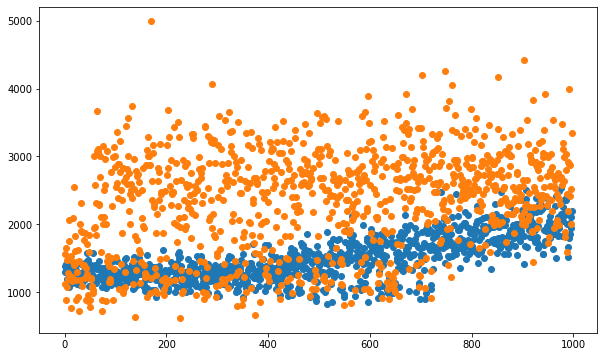

In [28]:
def getMovingAve(movingAveSize, scores):  # Moving average of all game scores
    movingAve = []
    
    for i in range(len(scores) // movingAveSize):
        if (i + 1) * movingAveSize < len(scores):
            movingAve.append(np.mean(scores[i*movingAveSize:(i+1)*movingAveSize]))
    return movingAve


def mapScores():
    movingAveSize = 5
    
    movingAveA = getMovingAve(movingAveSize*5, gameScoreLog)
    movingAveB = getMovingAve(movingAveSize, greedyScoreLog)
    
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(len(movingAveA)),movingAveA)
    plt.scatter(np.arange(len(movingAveB)),movingAveB)
    
mapScores()

## Test the Agent

Run 100 times using the trained agent for testing. Print the score and the maximum value attained from each test game.

In [72]:
def testAgent():
    games = 100
    
    scores = np.zeros(games)
    maxscores = np.zeros(games)
    
    for i in range(games):
        scores[i], maxscores[i] = (run(initializeEnv(),agent,memCount,True))
    
    print("Average Score: ", np.mean(scores))
    print("Std Deviation: ", format(np.std(scores),'.2f'))
    print("Time elapsed:  ", format(time.time() - startTime, '.2f'))
    unique, counts = np.unique(scores, return_counts=True)
    print(np.asarray((unique, counts)).T)
    unique_max, counts_max = np.unique(maxscores, return_counts=True)
    print(np.asarray((unique_max, counts_max)).T)
    
    return scores
    

testAgent()

Average Score:  2804.96
Std Deviation:  1000.76
Time elapsed:   118345.89
[[3.800e+02 1.000e+00]
 [1.132e+03 1.000e+00]
 [1.208e+03 1.000e+00]
 [1.228e+03 1.000e+00]
 [1.432e+03 1.000e+00]
 [1.500e+03 1.000e+00]
 [1.564e+03 2.000e+00]
 [1.608e+03 1.000e+00]
 [1.672e+03 1.000e+00]
 [1.676e+03 3.000e+00]
 [1.680e+03 2.000e+00]
 [1.708e+03 1.000e+00]
 [1.720e+03 2.000e+00]
 [1.724e+03 1.000e+00]
 [1.852e+03 1.000e+00]
 [1.864e+03 2.000e+00]
 [1.868e+03 2.000e+00]
 [1.872e+03 1.000e+00]
 [1.884e+03 2.000e+00]
 [1.912e+03 1.000e+00]
 [1.916e+03 1.000e+00]
 [1.992e+03 1.000e+00]
 [1.996e+03 2.000e+00]
 [2.008e+03 1.000e+00]
 [2.176e+03 1.000e+00]
 [2.252e+03 1.000e+00]
 [2.364e+03 1.000e+00]
 [2.492e+03 1.000e+00]
 [2.520e+03 1.000e+00]
 [2.572e+03 1.000e+00]
 [2.588e+03 1.000e+00]
 [2.604e+03 1.000e+00]
 [2.620e+03 3.000e+00]
 [2.632e+03 2.000e+00]
 [2.716e+03 1.000e+00]
 [2.744e+03 1.000e+00]
 [2.748e+03 1.000e+00]
 [2.760e+03 2.000e+00]
 [2.876e+03 1.000e+00]
 [2.888e+03 1.000e+00]
 [2.89

array([2632., 2364., 1852., 3356., 4296., 3340., 3216., 2620., 3544.,
       1432., 4440., 1676., 1996., 2620., 4300., 2940., 1680., 3668.,
       2992., 3512., 4152., 2904., 1720., 5464., 1608., 1996., 2716.,
       1564., 2008., 2604., 2744., 2176., 1132., 3016., 1564., 3704.,
       1916., 2492., 1680., 2908., 3324., 5836., 2748., 4296., 3532.,
       2620., 3468., 3064., 1992., 1672., 2888., 2520., 2632., 3512.,
       1500., 1208.,  380., 2572., 3656., 2588., 4252., 1724., 3960.,
       4024., 1864., 3772., 3960., 3912., 4120., 1864., 3468., 3500.,
       1868., 1676., 1720., 1228., 2940., 3464., 2892., 1708., 1912.,
       3352., 3152., 3192., 4488., 3532., 2760., 3660., 2252., 3356.,
       3536., 1872., 1676., 2760., 1884., 4104., 2876., 1884., 1868.,
       3912.])

In [2]:
fs = [2632., 2364., 1852., 3356., 4296., 3340., 3216., 2620., 3544.,
       1432., 4440., 1676., 1996., 2620., 4300., 2940., 1680., 3668.,
       2992., 3512., 4152., 2904., 1720., 5464., 1608., 1996., 2716.,
       1564., 2008., 2604., 2744., 2176., 1132., 3016., 1564., 3704.,
       1916., 2492., 1680., 2908., 3324., 5836., 2748., 4296., 3532.,
       2620., 3468., 3064., 1992., 1672., 2888., 2520., 2632., 3512.,
       1500., 1208.,  380., 2572., 3656., 2588., 4252., 1724., 3960.,
       4024., 1864., 3772., 3960., 3912., 4120., 1864., 3468., 3500.,
       1868., 1676., 1720., 1228., 2940., 3464., 2892., 1708., 1912.,
       3352., 3152., 3192., 4488., 3532., 2760., 3660., 2252., 3356.,
       3536., 1872., 1676., 2760., 1884., 4104., 2876., 1884., 1868.,
       3912]

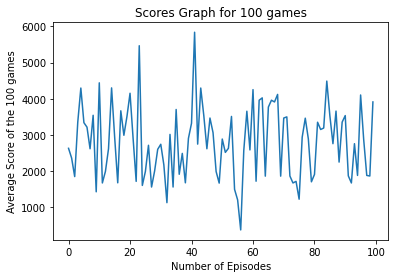

In [7]:
plt.plot(fs)
plt.title('Scores Graph for 100 games')
plt.xlabel('Number of Episodes')
plt.ylabel('Average Score of the 100 games')
plt.show()